In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

### Get data

Data is a list of 5 letter words used to play `wordle` game.

In [2]:
import requests
url = "https://raw.githubusercontent.com/charlesreid1/five-letter-words/master/sgb-words.txt"
resp = requests.get(url)
print(f"Satus_code : {resp.status_code}")
with open("words.txt", "w") as fout:
    fout.write(resp.text)

Satus_code : 200


### Read Data

In [3]:
with open("words.txt", "r") as fin:
    words = fin.readlines()

words = [ w.strip() for w in words if len(w) > 2 ]
print(f"File read. Number of words = {len(words)}")
print(words[:10])

File read. Number of words = 5757
['which', 'there', 'their', 'about', 'would', 'these', 'other', 'words', 'could', 'write']


### Convert to char vectors

1. Given a word convert to one-hot character vectors
2. Pad the words with start `(` and end `)` tokens.


In [4]:
from string import ascii_lowercase
char_map = {c:i+1 for i,c in enumerate(ascii_lowercase)}
char_map["("] = 0
char_map[")"] = 27
print(char_map)
def word_to_char_vec(word:str):
    ''' Convert a given word to character vecs '''
    l = len(word)
    vecs = np.zeros((l+2,28))
    # print(vecs.shape)
    for i,c in enumerate( f"({word})" ):
        vecs[i,char_map[c]] = 1.0
    return np.expand_dims(vecs, axis=0)

print(word_to_char_vec("abcd"))



{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '(': 0, ')': 27}
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 1.]]]


### Convert all word to char vecs

In [5]:
char_vecs = list(map(word_to_char_vec, words))
char_vecs_np = np.vstack(char_vecs)
print(char_vecs_np.shape)

(5757, 7, 28)


### Craete autoencoder model

In [6]:
def create_model(seq_len=7,dim=28):
    tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32,return_sequences=True, input_shape=(seq_len,dim)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(8*seq_len, activation="relu"),
        tf.keras.layers.Reshape((seq_len,8)),
        # tf.keras.layers.LSTM(32,return_sequences=True),
        tf.keras.layers.LSTM(dim,return_sequences=True, activation="linear"),
        tf.keras.layers.Softmax()
    ])

    model.compile(loss="mse", optimizer="adam")
    model.summary()
    return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 32)             7808      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 56)                3640      
                                                                 
 reshape (Reshape)           (None, 7, 8)              0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 28)             4144      
                                                                 
 softmax (Softmax)           (None, 7, 28)             0

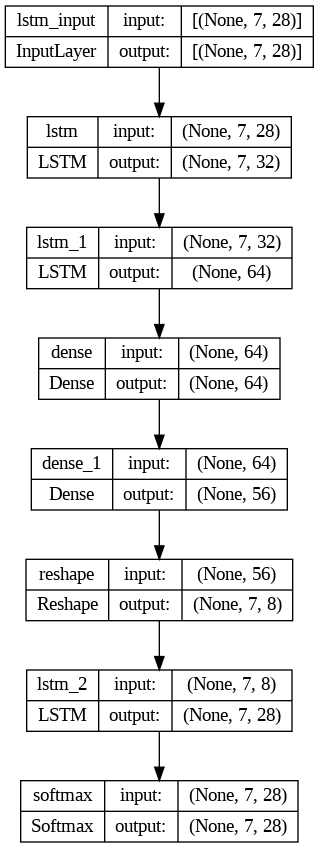

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True )

### Now lets Train the Model

<AxesSubplot:>

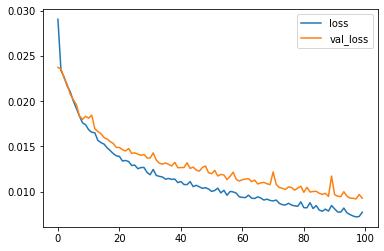

In [8]:
X = char_vecs_np
hist = model.fit(X,X, batch_size=32, epochs=100, verbose=0, validation_split=0.2)
hdf = pd.DataFrame(hist.history)
hdf.plot()

In [18]:
losses = pd.concat([hdf.head(5) , hdf.tail(5)])
losses.index.name = "epoch"
losses

,loss,val_loss
epoch,,
0,0.029067,0.023740
1,0.023379,0.023572
2,0.022682,0.022564
3,0.021713,0.021887
4,0.021058,0.020794
95,0.007474,0.009294
96,0.007311,0.009267
97,0.007209,0.009200
98,0.007259,0.009690
